# 0. Solution Planning

## 0.1. Input

1. Business Problem
    - Select most valuable clientsto be part of a loyalty program

2. Dataset
    - Sales from an e-commerce during one year

## 0.2. Output

1. People indication to be part of the loyalty program
    - List of clients tagged

2. Report with the business questions

    - Who are the elegible people to participate in the loyalty program?
    - How many clients will be part of the loyalty program?
    - Which are the main client characteristics?
    - What is the percentage of profit contribution that comes from the loyalty program?
    - What is the profit expectation from this group in the next months?
    - What are the conditions that makes someone elegible to the loyalty program?
    - What are the conditions that makes someone not elegible anymore to the loyalty program?
    - What are the metrics to decide if the loyalty program people are really better than the rest of the database?
    - What could the marketing team do to improve the profit?

## 0.3. Tasks

Who are the elegible people to participate in the loyalty program?
- High average ticket;
- High LTV (Life Time Value);
- High purchase frequency;
- High basket size;
- Low churn probability;
- High purchase propensity.
- Low number of devolutions;
- Experience;
- High number of ratings.

How many clients will be part of the loyalty program?
- Percentage of total clients.

What are the main client characteristics?
- Important client attributes (age, country, salary);
- Client purchasing behavior.

What is the percentage of profit contribution that comes from the loyalty program?
- Get the total profit of the company during the year and the percentage of the cluster.

What is the profit expectation from this group in the next months?
- Get the loyalty program LTV;
- Build a time series.

What are the conditions that make someone elegible to the loyalty program?
- The average performance of the client is close to the average performance of the clients from the loyalty program.

What are the conditions that make someone not elegible anymore to the loyalty program?
- The client average performance is not close to the loyalty program average anymore.

What are the metrics to decide if the loyalty program people are really better than the rest of the database?
- Hypothesis testing;
- A/B testing.

What could the marketing team do to improve the profit?
- Discounts;
- Choosing preferences;
- Exclusive products.

# 1. Imports

In [29]:
import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt
from IPython.display import HTML

from sklearn import cluster as c
from sklearn import metrics as m
from yellowbrick.cluster import KElbowVisualizer

## 1.1. Helper Functions

In [30]:
def settings():

    %matplotlib inline
    plt.style.use('ggplot')
    plt.rcParams['figure.figsize'] = [10, 5]
    plt.rcParams['font.size'] = 24

    display(HTML('<style>.container { width:100% !important; }</style>'))

    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.float_format', lambda x: '%.4f' % x)
    pd.set_option('display.expand_frame_repr', False)

    sns.set()

settings()

## 1.2. Load Dataset

In [31]:
df_raw = pd.read_csv('../data/Ecommerce.csv', encoding='unicode_escape')

df_raw.drop(columns=['Unnamed: 8'], inplace=True)

In [32]:
df_raw.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.5500,17850.0000,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.3900,17850.0000,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.7500,17850.0000,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.3900,17850.0000,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.3900,17850.0000,United Kingdom


# 2. Data Description

In [33]:
df1 = df_raw.copy()

## 2.1. Rename Columns

In [34]:
cols_new = ['invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date', 'unit_price', 'customer_id', 'country']

df1.columns = cols_new

## 2.2. Data Dimension

In [35]:
print('Number of Rows: {}'.format(df1.shape[0]))
print('Number of Cols: {}'.format(df1.shape[1]))

Number of Rows: 541909
Number of Cols: 8


## 2.3. Check NA

In [36]:
df1.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

## 2.4. Replace NA

In [37]:
# remove na
df1 = df1.dropna(subset=['description', 'customer_id'])
print('Removed data: {:.2f}%'.format((1 - (df1.shape[0] / df_raw.shape[0])) * 100))

Removed data: 24.93%


In [38]:
df1.isna().sum()

invoice_no      0
stock_code      0
description     0
quantity        0
invoice_date    0
unit_price      0
customer_id     0
country         0
dtype: int64

## 2.6. Check Data Types

In [39]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

## 2.4. Change Data Types

In [40]:
# invoice_date
df1['invoice_date'] = pd.to_datetime(df1['invoice_date'], format='%d-%b-%y')

# customer_id
df1['customer_id'] = df1['customer_id'].astype(int)

In [41]:
df1.dtypes

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
customer_id              int32
country                 object
dtype: object

## 2.7. Descriptive Statistics

# 3. Feature Engineering

In [42]:
df2 = df1.copy()

## 3.1. Feature Creation

In [43]:
# data reference
df_ref = df2.drop(['invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date', 'unit_price', 'country'], axis=1)
df_ref = df_ref.drop_duplicates(ignore_index=True)

In [44]:
# gross revenue (profit) quantity * price
df2['gross_revenue'] = df2['quantity'] * df2['unit_price']

# monetary
df_monetary = df2[['customer_id', 'gross_revenue']].groupby('customer_id').sum().reset_index()
df_ref = pd.merge(df_ref, df_monetary, on='customer_id', how='left')

# recency (last day purchase)
df_recency = df2[['customer_id', 'invoice_date']].groupby('customer_id').max().reset_index()
df_recency['recency_days'] = (df2['invoice_date'].max() - df_recency['invoice_date']).dt.days
df_recency = df_recency[['customer_id', 'recency_days']].copy()
df_ref = pd.merge(df_ref, df_recency, on='customer_id', how='left')

# frequency
df_freq = df2[['customer_id', 'invoice_no']].drop_duplicates().groupby('customer_id').count().reset_index()
df_ref = pd.merge(df_ref, df_freq, on='customer_id', how='left')

In [45]:
df_ref.head()

,customer_id,gross_revenue,recency_days,invoice_no
0,17850,5288.6300,302,35
1,13047,3079.1000,31,18
2,12583,7187.3400,2,18
3,13748,948.2500,95,5
4,15100,635.1000,330,6


# 4. Variable Filtering

In [46]:
df3 = df_ref.copy()

# 5. EDA (Exploratory Data Analysis)

In [47]:
df4 = df3.copy()

# 6. Data Preparation

In [48]:
df5 = df4.copy()

# 7. Feature Selection

In [49]:
df6 = df5.copy()

# 8. Hyperparameter Fine Tuning

In [50]:
X = df6.drop(columns=['customer_id'])

In [51]:
clusters = [2, 3, 4, 5, 6]

## 8.1. Within Cluster Sum of Square (WSS)

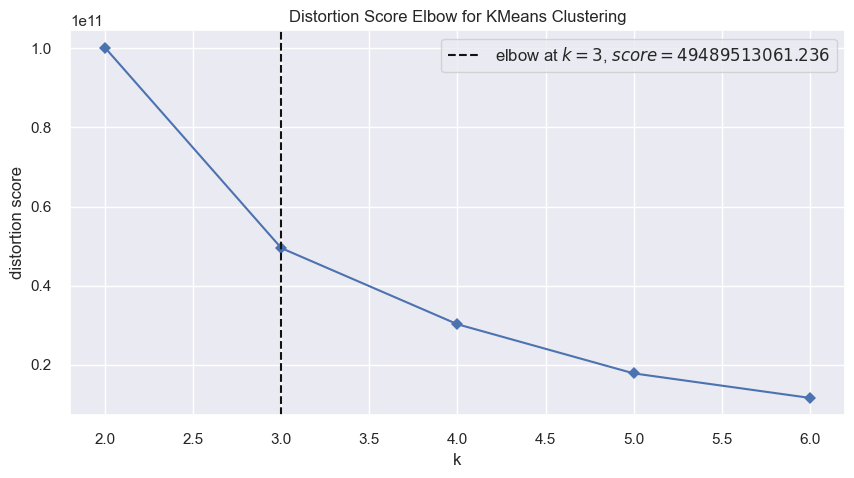

In [52]:
kmeans = KElbowVisualizer(c.KMeans(), k=clusters, timings=False)
kmeans.fit(X)
kmeans.show();

## 8.2. Silhouette Score

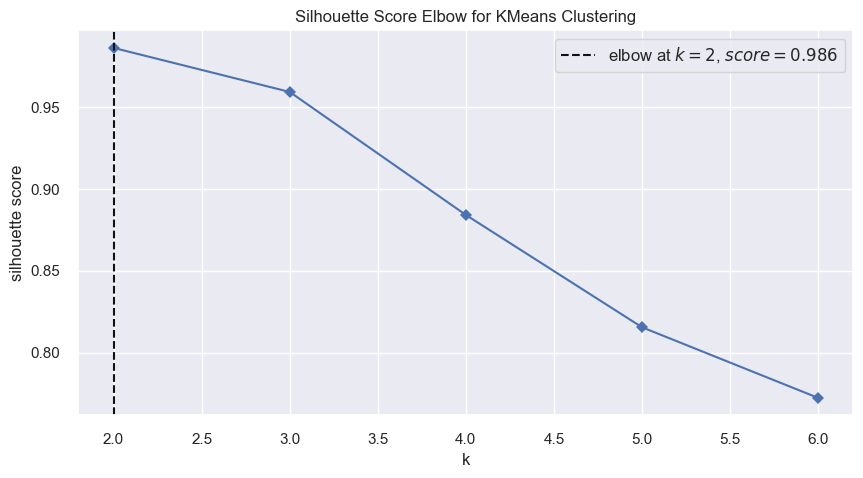

In [53]:
kmeans = KElbowVisualizer(c.KMeans(), k=clusters, metric='silhouette', timings=False)
kmeans.fit(X)
kmeans.show();

# 9. Model Training

## 9.1. K-Means

In [54]:
# model definition
k=3
kmeans = c.KMeans(init='random', n_clusters=k, n_init=10, max_iter=300, random_state=42)

# model training
kmeans.fit(X)

# clustering
labels = kmeans.labels_

## 9.2. Cluster Validation

In [55]:
# WSS
print('WSS Value: {}'.format(kmeans.inertia_))

# SS
print('SS Value: {}'.format(m.silhouette_score(X, labels, metric='euclidean')))

WSS Value: 52830442008.006966
SS Value: 0.9494677566681542


# 10. Cluster Analysis

In [ ]:
# 1:12:30

# 11. Deployment